# CONVOLUTIONAL NEURAL NETWORK
## FOR FACE RECOGNITION

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  
print ("Packages loaded")

Packages loaded


# LOAD DATA

In [2]:
# LOAD DATA
cwd = os.getcwd()
loadpath = cwd + "/data.npz"
l = np.load(loadpath)
print (l.files)

# PARSE LOADED DATA
trainimg   = l['trainimg']
trainlabel = l['trainlabel']
testimg    = l['testimg']
testlabel  = l['testlabel']
imgsize    = l['imgsize']
categories = l['categories']

ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d TRAIN IMAGES" % (ntrain))
print ("%d TEST IMAGES" % (ntest))
print ("%d DIMENSIONAL INPUT" % (dim))
print ("%d CLASSES" % (nclass))
print (imgsize)
print (categories)

['imgsize', 'trainimg', 'categories', 'trainlabel', 'testlabel', 'testimg']
10042 TRAIN IMAGES
2511 TEST IMAGES
2304 DIMENSIONAL INPUT
7 CLASSES
[48 48  1]
['Angry' 'Disgust' 'Fear' 'Happy' 'Sad' 'Surprise' 'Neutral']


# DEFINE MODEL

In [3]:
tf.set_random_seed(0)

# MULTILAYER PERCEPTRON MODEL
n_input    = dim    # INPUT LAYER DIMENSION
n_filter1  = 128    # NUMBER OF FILTERS IN CONV1 
n_filter2  = 256    # NUMBER OF FILTERS IN CONV2
n_hid      = 256    # NUMBER OF HIDDEN LAYER NODES
n_output   = nclass # OUTPUT LAYER DIMENSION
x = tf.placeholder("float", [None, dim]) 
y = tf.placeholder("float", [None, nclass]) 

std = 0.1
with tf.variable_scope("CNN_WEIGHTS"):
    W = {
        'wc1': tf.Variable(tf.random_normal([3, 3, imgsize[2], n_filter1], stddev=std)),
        'wc2': tf.Variable(tf.random_normal([3, 3, n_filter1, n_filter2], stddev=std)),
        'wd1': tf.Variable(tf.random_normal(
                [(int)(imgsize[0]/4*imgsize[1]/4)*n_filter2, n_hid], stddev=std)),
        'wd2': tf.Variable(tf.random_normal([n_hid, n_output], stddev=std))
    }
with tf.variable_scope("CNN_BIASES"):
    b = {
        'bc1': tf.Variable(tf.random_normal([n_filter1], stddev=std)),
        'bc2': tf.Variable(tf.random_normal([n_filter2], stddev=std)),
        'bd1': tf.Variable(tf.random_normal([n_hid], stddev=std)),
        'bd2': tf.Variable(tf.random_normal([n_output], stddev=std))
    }
x = tf.placeholder("float", [None, dim], name="CNN_INPUT_X")
y = tf.placeholder("float", [None, nclass], name="CNN_TARGET_Y")
keepratio = tf.placeholder(tf.float32, name="CNN_DROPOUT_KR")

print ("CNN PARAMETERS READY")

CNN PARAMETERS READY


In [4]:
def convolutional_neural_network(_x, _w, _b, _imgsize, _keepratio):
    with tf.variable_scope("INPUT_LAYER"):
        _input_r = tf.reshape(_x, shape=[-1, _imgsize[0], _imgsize[1], _imgsize[2]])
    # CONVOLUTION LAYER 1
    with tf.variable_scope("CONV_1"):
        _conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_input_r
            , _w['wc1'], strides=[1, 1, 1, 1], padding='SAME'), _b['bc1']))
        _pool1 = tf.nn.max_pool(_conv1, ksize=[1, 2, 2, 1]
            , strides=[1, 2, 2, 1], padding='SAME')
    # CONVOLUTION LAYER 2
    with tf.variable_scope("CONV_2"):
        _conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_pool1
            , _w['wc2'], strides=[1, 1, 1, 1], padding='SAME'), _b['bc2']))
        _pool2 = tf.nn.max_pool(_conv2, ksize=[1, 2, 2, 1]
            , strides=[1, 2, 2, 1], padding='SAME')
        _pool2_dr = tf.nn.dropout(_pool2, _keepratio)
        _dense1 = tf.reshape(_pool2_dr
                             , [-1, _w['wd1'].get_shape().as_list()[0]])
    # DENSE LAYER 1
    with tf.variable_scope("FC_1"):
        _fc1 = tf.nn.relu(tf.add(tf.matmul(_dense1, _w['wd1']), _b['bd1']))
        _fc1_dr = tf.nn.dropout(_fc1, _keepratio)
    # OUTPUT LAYER 2
    with tf.variable_scope("FC_2"):
        _out = tf.add(tf.matmul(_fc1_dr, _w['wd2']), _b['bd2'])
    # RETURN
    out = {
        'input_r': _input_r, 'conv1': _conv1, 'pool1': _pool1
        , 'conv2': _conv2, 'pool2': _pool2
        , 'dense1': _dense1, 'fc1': _fc1, 'fc_dr1': _fc1_dr, 'out': _out
    }
    return out
print ("CONVOLUTIONAL NEURAL NETWORK MODEL READY")

CONVOLUTIONAL NEURAL NETWORK MODEL READY


# DEFINE FUNCTIONS

In [5]:
learning_rate = 0.001
pred = convolutional_neural_network(x, W, b, imgsize, keepratio)['out']
ce_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) 
WEIGHT_DECAY_FACTOR = 0.01
l2_loss = tf.add_n([tf.nn.l2_loss(v) 
            for v in tf.trainable_variables()])
cost = ce_cost + WEIGHT_DECAY_FACTOR*l2_loss
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, tf.float32))
init = tf.initialize_all_variables()
print ("FUNCTIONS READY")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
FUNCTIONS READY


# SUMMARY

In [6]:
session_conf = tf.ConfigProto()
session_conf.gpu_options.allow_growth = True

# LAUNCH THE GRAPH
sess = tf.Session(config=session_conf)
sess.run(init)

tf.scalar_summary('CROSS ENTROPY COST', cost)
tf.scalar_summary('ACCURACY', accr)
merged = tf.merge_all_summaries()
summary_writer = tf.train.SummaryWriter('log_cnn', graph=sess.graph)
print ("SUMMARY READY")

SUMMARY READY


## ON THE COMMAND LINE
#### tensorboard --logdir=/tmp/tf_logs/cnn_mnist
## OPEN FOLLOWING LINK
#### http://localhost:6006/

# RUN

Epoch: 000/500 cost: 401.101394653
2030 MISSED


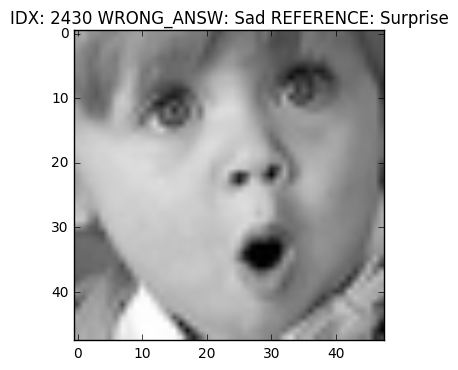

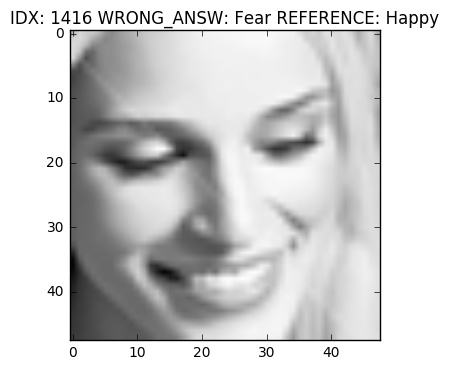

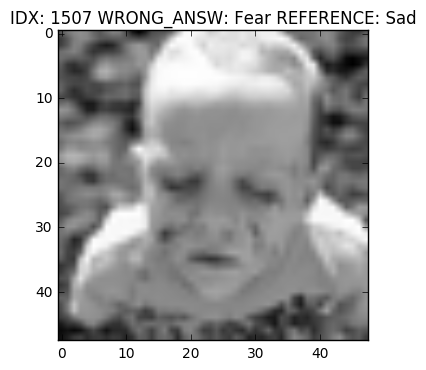

 TRAIN ACCURACY: 0.199
 TEST ACCURACY: 0.191
Epoch: 050/500 cost: 1.680686462
1074 MISSED


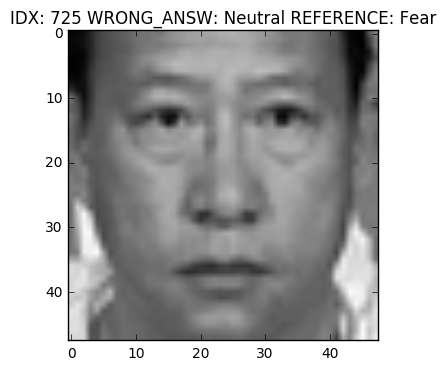

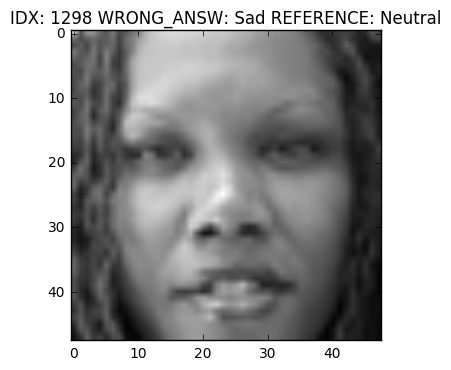

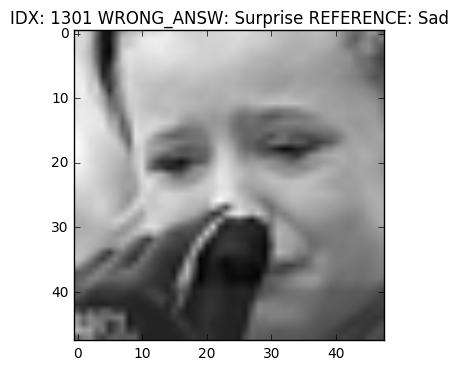

 TRAIN ACCURACY: 0.735
 TEST ACCURACY: 0.572


KeyboardInterrupt: 

In [7]:
# PARAMETERS
batch_size      = 256
display_step    = 50
training_epochs = 500
num_batch = int(ntrain/batch_size)+1
for epoch in range(training_epochs):
    avg_cost = 0.
    randpermlist = np.random.permutation(ntrain)
    for i in range(num_batch): 
        randidx  = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_xs = trainimg[randidx, :]
        batch_ys = trainlabel[randidx, :]                
        feeds    = {x: batch_xs, y: batch_ys, keepratio: 0.7}
        # OPTIMIZE VARIABLES
        summary, _ = sess.run([merged, optm], feed_dict=feeds)
        # COMPUTE LOSS
        avg_cost += sess.run(cost, feed_dict=feeds)/num_batch
        # SUMMARY
        summary_writer.add_summary(summary, epoch*num_batch+i)
        
    # PRINT CURRENT STATUS
    if epoch % display_step == 0 or epoch == training_epochs-1:
        print ("Epoch: %03d/%03d cost: %.9f" % 
               (epoch, training_epochs, avg_cost))      
        ntemp = int(ntrain/batch_size)+1
        train_acc = 0
        for ii in range(ntemp):
            iii = np.arange(ii*batch_size, min(ntrain, (ii+1)*batch_size))
            feeds = {x: trainimg[iii, :], y: trainlabel[iii, :], keepratio: 1.0}
            train_acc = train_acc + sess.run(accr, feed_dict=feeds)
        train_acc = train_acc / ntemp            
        ntemp = int(ntest/batch_size) + 1 
        test_acc = 0
        missidxlist = []
        for ii in range(ntemp):
            iii = np.arange(ii*batch_size, min(ntest, (ii+1)*batch_size))
            feeds = {x: testimg[iii, :], y: testlabel[iii, :], keepratio: 1.0}
            test_acc = test_acc + sess.run(accr, feed_dict=feeds)
            # FIND MISCLASSIFIED IMAGES
            missidx = np.where(sess.run(corr, feed_dict=feeds) == 0)[0]
            missidxlist = np.concatenate((missidxlist, iii[missidx]))
        test_acc = test_acc / ntemp
        
        
        nmiss = len(missidxlist)
        print ("%d MISSED" % (nmiss))
        missidxlist = np.random.permutation(missidxlist.astype(int))
        selmissidx  = missidxlist[:min(3, nmiss)].astype(int)
        feeds_miss  = {x: testimg[selmissidx, :], y: testlabel[selmissidx, :], keepratio: 1.0}
        pred_miss   = sess.run(pred, feed_dict=feeds_miss)
        answ_miss   = np.argmax(pred_miss, 1)
        answ_corr   = np.argmax(testlabel[selmissidx, :], 1)
        for idx in range(len(selmissidx)):
            cidx = selmissidx[idx]
            anw  = answ_miss[idx]
            ref  = answ_corr[idx]
            if imgsize[2] == 1:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1]))
                plt.imshow(currimg, cmap='gray')
            else:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1], -1))
                plt.imshow(currimg)
            anw_category = categories[anw]
            ref_category = categories[ref]
            title_string = "IDX: %d WRONG_ANSW: %s REFERENCE: %s" % (cidx, anw_category, ref_category)
            plt.title(title_string) 
            plt.show() 
        
        
        print (" TRAIN ACCURACY: %.3f" % (train_acc))
        print (" TEST ACCURACY: %.3f" % (test_acc))
        
print ("OPTIMIZATION FINISHED") 